## BECS 2 Data Challenge: Predicting Cancer Status of Patients
Koch Kilian (ZHAW), Rieder Jonathan (ZHAW), Yar Kevin (ZHAW)

The aim of this project work is to predict 6 different healt status of patients (healthy, breast-, lung-, pancreatic-, colorectal- and prostate cancer). The prediction is based on mass spectroscopy data of different protein levels meassured in patients blood. Detecting cancer based on so called biomarkers is a current field of research. Related publications are linked bellow:
https://ascopubs.org/doi/10.1200/JCO.19.02768?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed
https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/pmic.201600240
https://www.sciencedirect.com/science/article/pii/S0092867420308746?via%3Dihub

## Part 1: Loading packages and define initial Parameters

In [83]:
#import necessary packages 
import os
import random
import xgboost
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import dash_bio
import eli5
from sklearn.tree import export_graphviz
from subprocess import call

from math import log2, log10
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn_genetic import GAFeatureSelectionCV

os.getcwd()
"""
usage joblib
# save the model: 
joblib.dump(model , "model.pkl")
# load the model:
model = joblib.load("model.pkl")
"""

'\nusage joblib\n# save the model: \njoblib.dump(model , "model.pkl")\n# load the model:\nmodel = joblib.load("model.pkl")\n'

## Part 2: Data Preprocessing
In this section the raw data is visualised, preprocessed and checked

In [84]:
#create pandas dataframe
path = "./RawData/tidy.csv"
pathMet = "./RawData/metadata.csv"
tidy = pd.read_csv(path, sep=",")
tidyMet = pd.read_csv(pathMet, sep=";", index_col=0)

In [85]:
#remove samples which are not in the metadata index column (quality control etc)
tidy = tidy[ (tidy["R.FileName"].isin(tidyMet.index)) ]
tidyMer    = pd.merge(tidy, tidyMet, how="left", on="R.FileName")
tidySub = tidyMer[["R.FileName", "uniprot", "meanAbu", "Cancer"]]
tidySub.Cancer.value_counts()

Breast Cancer        84630
Lung Cancer          81900
Pancreatic Cancer    81900
Colorectal Cancer    81900
Healthy              81900
Prostate Cancer      81900
Name: Cancer, dtype: int64

In [86]:
tidySub.head()

,R.FileName,uniprot,meanAbu,Cancer
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6H9,11601.398438,Lung Cancer
1,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I0,3827.466797,Lung Cancer
2,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I1,114115.796875,Lung Cancer
3,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I7,4293.524902,Lung Cancer
4,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6J1,5969.785645,Lung Cancer


In [87]:
#store data in list for each type of protein and cancer
ValueDF = tidySub.groupby(['uniprot','Cancer'])['meanAbu'].apply(list)
ValueDF = ValueDF.reset_index()
ValueDF.head()

,uniprot,Cancer,meanAbu
0,A0A075B6H9,Breast Cancer,"[35277.67578125, 34095.4765625, 3512.60546875,..."
1,A0A075B6H9,Colorectal Cancer,"[38555.5703125, 37487.71875, 28599.8984375, 42..."
2,A0A075B6H9,Healthy,"[168020.15625, 9181.5859375, 5460.25927734375,..."
3,A0A075B6H9,Lung Cancer,"[11601.3984375, 4950.046875, 4343.33154296875,..."
4,A0A075B6H9,Pancreatic Cancer,"[14946.3359375, 4416.61767578125, 30662.833984..."


In [88]:
# For the log2 values, we use MeanDF
MeanDF = tidySub.groupby(['uniprot','Cancer'])['meanAbu'].mean()
MeanDF = pd.DataFrame(MeanDF)
MeanDF = MeanDF.reset_index()

In [8]:
# each protein has a mean abu
MeanDF[MeanDF.uniprot == 'A0A075B6H9']

,uniprot,Cancer,meanAbu
0,A0A075B6H9,Breast Cancer,13187.140263
1,A0A075B6H9,Colorectal Cancer,11832.107357
2,A0A075B6H9,Healthy,39325.718099
3,A0A075B6H9,Lung Cancer,19166.234025
4,A0A075B6H9,Pancreatic Cancer,30563.667741
5,A0A075B6H9,Prostate Cancer,12818.901481


In [71]:

pivMeanDF = MeanDF.pivot_table(values='meanAbu', index=['uniprot'], columns='Cancer')
pivMeanDF = pivMeanDF.reset_index()

pivMeanDF

Cancer,uniprot,Breast Cancer,Colorectal Cancer,Healthy,Lung Cancer,Pancreatic Cancer,Prostate Cancer
0,A0A075B6H9,1.318714e+04,1.183211e+04,3.932572e+04,1.916623e+04,3.056367e+04,1.281890e+04
1,A0A075B6I0,3.631717e+04,4.091292e+04,1.762420e+05,2.695806e+04,4.795375e+04,3.296956e+04
2,A0A075B6I1,7.822352e+03,9.022135e+03,1.490596e+04,1.153265e+04,1.936417e+04,7.794840e+03
3,A0A075B6I7,4.667722e+03,4.476476e+03,7.371171e+03,4.608651e+03,4.906442e+03,5.239455e+03
4,A0A075B6J1,4.698463e+03,4.946763e+03,1.183982e+04,4.522844e+03,4.827412e+03,4.552161e+03
...,...,...,...,...,...,...,...
2725,Q9Y6L6,4.778257e+03,4.403394e+03,5.230566e+03,4.800621e+03,6.226449e+03,4.530669e+03
2726,Q9Y6N7,2.217552e+04,1.983380e+04,2.968121e+04,1.977552e+04,2.108111e+04,1.959120e+04
2727,Q9Y6R7,5.230733e+06,4.153629e+06,4.056345e+06,3.988329e+06,6.262894e+06,4.160906e+06
2728,Q9Y6Y9,1.095217e+04,1.229225e+04,1.094369e+04,1.151679e+04,1.290667e+04,9.403463e+03


In [77]:
#Create dictionary and process all data in the dataframes
d = {}
for items in pivMeanDF.columns[1:]:
    if items == 'Healthy':
        next
    else:
        print(items)
        name = (str(items.replace(" ", "")).lower())
        d[name] = pd.DataFrame(pivMeanDF[['uniprot', items, 'Healthy']])
        
        d[name] = d[name].set_index('uniprot')
        
        for protein in d[name].index:
        
            x = ValueDF[(ValueDF.uniprot == protein) & (ValueDF.Cancer == items)].meanAbu.values[0]
            y = ValueDF[(ValueDF.uniprot == protein) & (ValueDF.Cancer == 'Healthy')].meanAbu.values[0]
            d[name].at[protein, 'pvalue']  = stats.ttest_ind(x, y).pvalue
            d[name].pvalue.apply((log10))
            d[name].pvalue.multiply(-1)
            
            d[name]['L2F'] = np.log2(d[name][items] / d[name]['Healthy'])

Breast Cancer
Colorectal Cancer
Lung Cancer
Pancreatic Cancer
Prostate Cancer


#### Data Looks as followed:
* Every dict key is a cancer Type with the corresponding **dataframe** as value
#### Every **dataframe** contains:
* uniprot           = the uniprot identifier
* CancerX / Healthy = mean konzentration of the cancer and healthy sample
* p-value           = The p-value from a one-sided t-test comparing cancerX and healthy
* L2F               = The log2 of the ratio konzentration ratio $ L2F = log_{2}(\frac{Protein_{Cancer}}{Protein_{Healthy}}) $

In [80]:
print(d.keys())
d["prostatecancer"].head()

dict_keys(['breastcancer', 'colorectalcancer', 'lungcancer', 'pancreaticcancer', 'prostatecancer'])


Cancer,Prostate Cancer,Healthy,pvalue,L2F
uniprot,,,,
A0A075B6H9,12818.901481,39325.718099,0.020566,-1.617200
A0A075B6I0,32969.559180,176242.021566,0.003763,-2.418351
A0A075B6I1,7794.839966,14905.960042,0.050754,-0.935298
A0A075B6I7,5239.454541,7371.170549,0.378721,-0.492477
A0A075B6J1,4552.160962,11839.818555,0.037444,-1.379023


In [36]:
joblib.dump(d, 'volcanoplot_data')

['volcanoplot_data']

#### Set the parameter for the vulcano plot 
#### points of interest are proteins with;
* p-value < 0.05 
* Fold Change >= 2

In [66]:
params = dict(
    template = "ggplot2",
    effect_size='L2F',
    p='pvalue',
    snp = 'uniprot',
    gene=None,
    logp=True,
    title="Vulcanoplot " + i,
    xlabel="log2( Fold Change )",
    effect_size_line_width=np.log2(2),
    effect_size_line_color='#AB63FA',

    genomewideline_value=-np.log10(0.05), #p-value treshhold = 0.05
    genomewideline_width=2,
    genomewideline_color='#EF553B',

    highlight_color='#119DFF',
    col='#2A3F5F',
    autosize=False
)

In [65]:
i = "breastcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [67]:
i = "colorectalcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [68]:
i = "lungcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [69]:
i = "pancreaticcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [70]:
i = "prostatecancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

#### To use these proteins of interest we filter the uniprot ID for part3: Data Preparation

In [172]:
protSel = []
for cancer in ["breastcancer", "colorectalcancer","lungcancer", "pancreaticcancer", "prostatecancer"]:
    #extract dataframe
    df = d[i]
    protSel.append(df[ (df.pvalue <= 0.05) & (df.L2F >= 2.0) | (df.L2F <= -2.0)].index.tolist())

protSel = list ( set ( np.concatenate(protSel) ) )    #remove duplicates

## Part 3: Data Preparation
In this section the raw data is prepared and reshaped to be fed into the different models. 
Additionaly the distribution of the input data is visualized to check if the data set is balanced. 
The data is converted into two main variables X (patiens and the coresponding protein quantities) and y (patients and the coresponding healt condition). 
Furthermore the data will be filtered to reduce noise. Moreover, further adjustments will be conducted to make the data suitable for model inputs.

In [89]:
#create pandas dataframe
#load data with protein quantities
path = "rawData/tidy.csv"

#load data for patients healt status
pathMet = "rawData/metadata.csv"
tidy = pd.read_csv(path, sep=",")
tidyMet = pd.read_csv(pathMet, sep=";", index_col=0)

#remove samples which are not in the metadata index column
tidy = tidy[ (tidy["R.FileName"].isin(tidyMet.index)) ]
tidyMer    = pd.merge(tidy, tidyMet, how="left", on="R.FileName")
tidySub = tidyMer[["R.FileName", "uniprot", "meanAbu", "Cancer"]]
tidySub.Cancer.value_counts()

Breast Cancer        84630
Lung Cancer          81900
Pancreatic Cancer    81900
Colorectal Cancer    81900
Healthy              81900
Prostate Cancer      81900
Name: Cancer, dtype: int64

In [90]:
#rank proteins by concentration
tidySub["Rank"] = tidySub.groupby(by=["R.FileName", "Cancer"])["meanAbu"].rank(ascending=False)
tidySub.head()

,R.FileName,uniprot,meanAbu,Cancer,Rank
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6H9,11601.398438,Lung Cancer,1090.0
1,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I0,3827.466797,Lung Cancer,2497.0
2,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I1,114115.796875,Lung Cancer,468.0
3,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I7,4293.524902,Lung Cancer,2325.0
4,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6J1,5969.785645,Lung Cancer,1538.0


### Data filtering

The following scatterplot shows **all the proteins** for each sample (different color) ranked by their concentration. 

The dataset shows a high range of protein concentration. From 75 to 580'412'224 A
 It is known in literature that biomarker measurements appear in the medium and low concentration range. 

75.6575622558594
580412224.0


Text(0, 0.5, 'protein konzentration / Abundance')

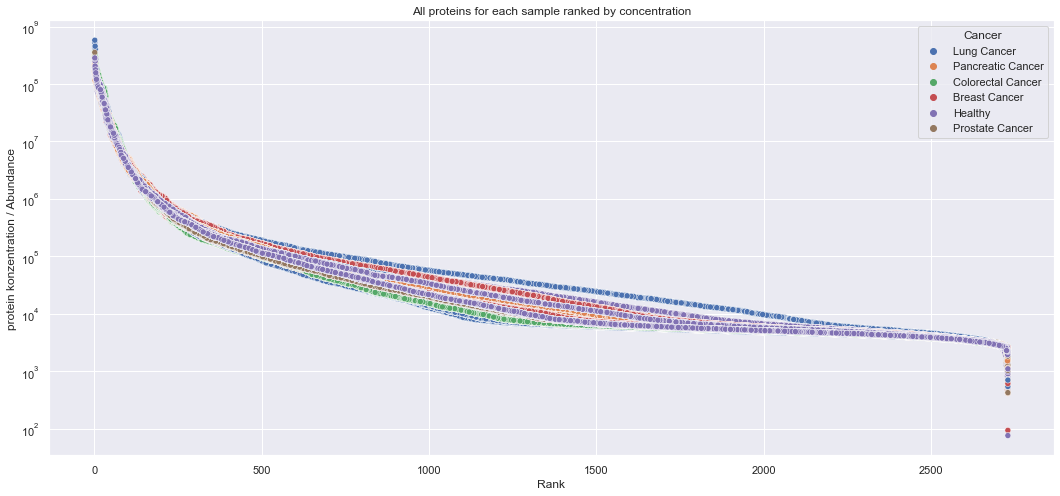

In [91]:
# With all proteins
print(tidySub.meanAbu.min())
print(tidySub.meanAbu.max())
sns.set(rc={'figure.figsize':(18,8)})
_ = sns.scatterplot(x="Rank", y="meanAbu", hue="Cancer", data=tidySub)
_.set_yscale("log")
_.set_title("All proteins for each sample ranked by concentration")
_.set_ylabel("protein konzentration / Abundance")
#_.legend_.remove()


#### Comparison to Part 2

To compare the concentration range of all proteins with the proteins of interest (part 2) the following plot shows only the later.

As we can see the conzentration range now is from 2353 to 142'926'176 A. 
We use this range of the proteins of interest to make a cutoff with the whole data with:
* from 2500 to 140'000'000 A

2353.3671875
142926176.0


Text(0, 0.5, 'protein konzentration / Abundance')

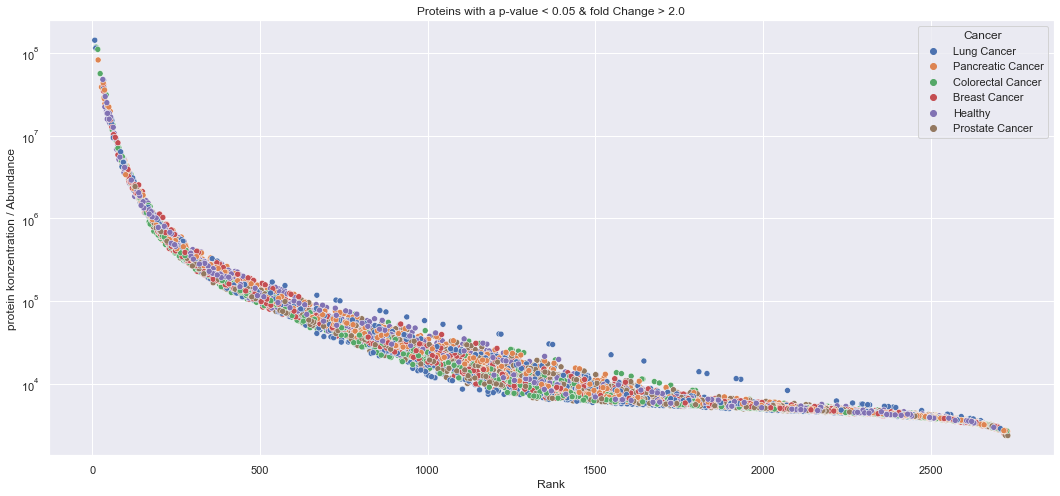

In [167]:
# With all proteins
print(tidySub[ tidySub.uniprot.isin(protSel) ].meanAbu.min())
print(tidySub[ tidySub.uniprot.isin(protSel) ].meanAbu.max())


sns.set(rc={'figure.figsize':(18,8)})
_ = sns.scatterplot(x="Rank", y="meanAbu", hue="Cancer", data=tidySub[ tidySub.uniprot.isin(protSel) ])
_.set_yscale("log")
_.set_title("Proteins with a p-value < 0.05 & fold Change > 2.0")
_.set_ylabel("protein konzentration / Abundance")
#_.legend_.remove()


Text(0, 0.5, 'protein konzentration / Abundance')

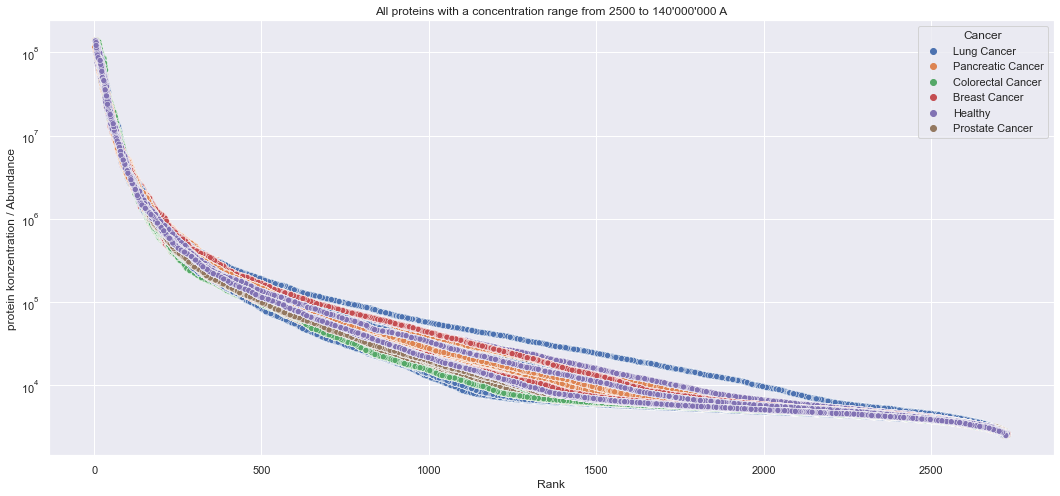

In [168]:
# With proteins in the range

tidySubFiltered = tidySub[ (tidySub.meanAbu <= 140000000) & (tidySub.meanAbu >=2500) ] 

sns.set(rc={'figure.figsize':(18,8)})
_ = sns.scatterplot(x="Rank", y="meanAbu", hue="Cancer", data=tidySubFiltered)
_.set_yscale("log")
_.set_title("All proteins with a concentration range from 2500 to 140'000'000 A")
_.set_ylabel("protein konzentration / Abundance")
#_.legend_.remove()



In [92]:
#reshape data for model
#X data
tidyReshaped = tidySubFiltered.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()

uniprot,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y696,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,NaN,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,21067.064453,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,NaN,6626.406738,100954.500000,1.029116e+06,15354.227539,...,231849.765625,37423.011719,32570.783203,16396.248047,5583.424316,NaN,17626.980469,3184120.25,19085.271484,125766.781250
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,NaN,NaN,7488.952148,15695.381836,4.025498e+04,70995.250000,...,43056.816406,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,NaN,1.193392e+04,26160.638672,...,27962.792969,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,28075.748047,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938


In [93]:
#y condition
Group =  tidySubFiltered.drop(["uniprot", "meanAbu", "Rank"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

,R.FileName,Cancer
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,Lung Cancer
1,J_D201211_MDIA_P705_SExp01-BGSID-10_R01,Lung Cancer
2,J_D201211_MDIA_P705_SExp01-BGSID-100_R01,Pancreatic Cancer
3,J_D201211_MDIA_P705_SExp01-BGSID-101_R01,Colorectal Cancer
4,J_D201211_MDIA_P705_SExp01-BGSID-102_R01,Lung Cancer


In [94]:
#merge X and y and set dataframe to numerical values
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")
data = data.set_index("R.FileName")

In [95]:
X_ = data.iloc[:, :-1].apply(np.log2)
y_ = data.iloc[:,-1]

#check head of the dataframe 
data.head()

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7,Cancer
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,NaN,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,NaN,6626.406738,100954.500000,1.029116e+06,15354.227539,...,37423.011719,32570.783203,16396.248047,5583.424316,NaN,17626.980469,3184120.25,19085.271484,125766.781250,Colorectal Cancer
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,NaN,NaN,7488.952148,15695.381836,4.025498e+04,70995.250000,...,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,NaN,1.193392e+04,26160.638672,...,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938,Breast Cancer


### Inputation

Due to the cutoff we end up with some proteins not having a value (NaN). Therefore the missing values need to be inputed.
To reduce the effect of outliers the median instead of the mean was used.

In [96]:
#Make pipeline and use median for NaN Values
dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X_)
X_.shape

(181, 2700)

### Encoding
Encode the different cancer types into numbers

In [97]:
# Encode target labels
labEnc = preprocessing.LabelEncoder() 
y = labEnc.fit_transform(y_) 

#show the encoding dictionair
cancerDict = dict(set(zip(y, y_)))
cancerTypes = list(cancerDict.items())
cancerTypes.sort()
cancerTypes


[(0, 'Breast Cancer'),
 (1, 'Colorectal Cancer'),
 (2, 'Healthy'),
 (3, 'Lung Cancer'),
 (4, 'Pancreatic Cancer'),
 (5, 'Prostate Cancer')]

In [43]:
# Save X and y for next session
joblib.dump(y, "Models2/y.pkl")
joblib.dump(X, "Models2/X.pkl")


['Models2/X.pkl']

In [113]:
# load saved X and y 
y = joblib.load("Models2/y.pkl")
X = joblib.load("Models2/X.pkl")


## Part 4: Feature Selection
For the feature selection different appraoches are applied and the results of the feature selection will be visualized. 

Random Forest and XGBoost is applied for feature selection. 

Furthermore both approaches are conducted once with the scklearn.feature_selection and with sklearn.genetic.GAFeatureSelection

### Random Forest Feature Selection:
* **sklearn.selectFromModel**

Original X shape: (181, 2700)
Feature selected X_new shape: (181, 100)


['Models2/featSel_RF.pkl']

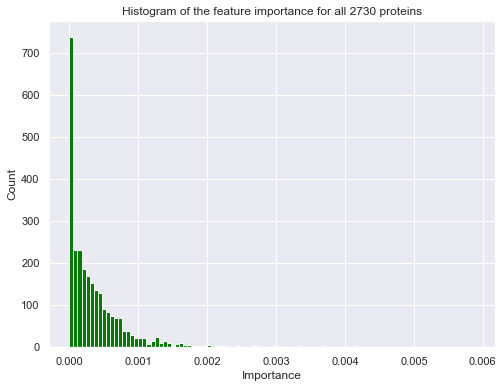

In [98]:
#skleanr.feature_selection
"""
Can be used in pipeline
clf = Pipeline([ 
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
#create Random Forest classifier with random hyperparameters
#params  = {'n_estimators': 114, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': False}
params = {}
clf_RA  = RandomForestClassifier(random_state=0, **params)
clf_RA.fit(X, y)

#checkout importance in a histogram
plt.figure(figsize=(8,6))
plt.hist(clf_RA.feature_importances_, bins=100, color='green')
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")


#get the reduced X
selector  = SelectFromModel(estimator = clf_RA, prefit=True
                            , max_features=100
                            )
X_RF      = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_RF.shape}")

joblib.dump(X_RF, "Models2/X_RF.pkl")
joblib.dump(selector.get_support(), "Models2/featSel_RF.pkl")


In [171]:
"""
# Visualize feature importance
importances = clf_RA.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf_RA.estimators_], axis=0)
std.sort()

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()
"""

'\n# Visualize feature importance\nimportances = clf_RA.feature_importances_\n\nstd = np.std([tree.feature_importances_ for tree in clf_RA.estimators_], axis=0)\nstd.sort()\n\nforest_importances = pd.Series(importances)\n\nfig, ax = plt.subplots()\nforest_importances.plot.bar(yerr=std, ax=ax)\nax.set_title("Feature importances using MDI")\nax.set_ylabel("Mean decrease in impurity")\nax.get_xaxis().set_visible(False)\nfig.tight_layout()\nplt.show()\n'

### Random Forest Feature Selection:
* **sklearn-genetic-opt.GAFeatureSelectionCV**

In [18]:
#sklearn_genetic.GAFeatureSelection

params  = {}
clf_RF    = RandomForestClassifier(random_state=0, **params)

evolved_estimator = GAFeatureSelectionCV(
    estimator   = clf_RF,
    cv          = None,
    population_size=20, 
    generations =40,
    crossover_probability=0.8,
    mutation_probability = 0.15,
    n_jobs      = -1,
    scoring     = "accuracy")

# Train and select the features
evolved_estimator.fit(X, y)

# Features selected by the algorithm
X_RFGA    = X[:, evolved_estimator.best_features_]

joblib.dump(X_RFGA, "Models2/X_RFGA.pkl")
joblib.dump(evolved_estimator.best_features_, "Models2/featSel_RFGA.pkl")


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.518438	0.0240641  	0.558408   	0.474925   
1  	38    	0.536884	0.020609   	0.58003    	0.486186   
2  	39    	0.543431	0.0147341  	0.56967    	0.508408   
3  	37    	0.549797	0.0159952  	0.585586   	0.524625   
4  	38    	0.56259 	0.0153072  	0.585586   	0.535736   
5  	38    	0.558236	0.0169524  	0.58033    	0.52012    
6  	38    	0.563956	0.0142029  	0.58033    	0.53003    
7  	39    	0.569047	0.0142998  	0.591141   	0.535736   
8  	39    	0.565736	0.0184711  	0.591141   	0.51967    
9  	38    	0.56783 	0.0162099  	0.591141   	0.519219   
10 	39    	0.569737	0.0123581  	0.591141   	0.546997   
11 	39    	0.564692	0.014018   	0.58033    	0.536036   
12 	39    	0.565676	0.0173624  	0.58033    	0.525075   
13 	39    	0.57012 	0.0190873  	0.585736   	0.514264   
14 	40    	0.575518	0.015486   	0.595946   	0.51952    
15 	38    	0.58033 	0          	0.58033    	0.58033    
16 	40    	0.580841	0.00153153 	0.585435   	0.58

### XGboost Feature Selection:
* **sklearn.selectFromModel**

C:\Users\kevin\anaconda3\envs\python38_r411\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Original X shape: (181, 2730)
Feature selected X_new shape: (181, 90)


['Models2/featSel_XG.pkl']

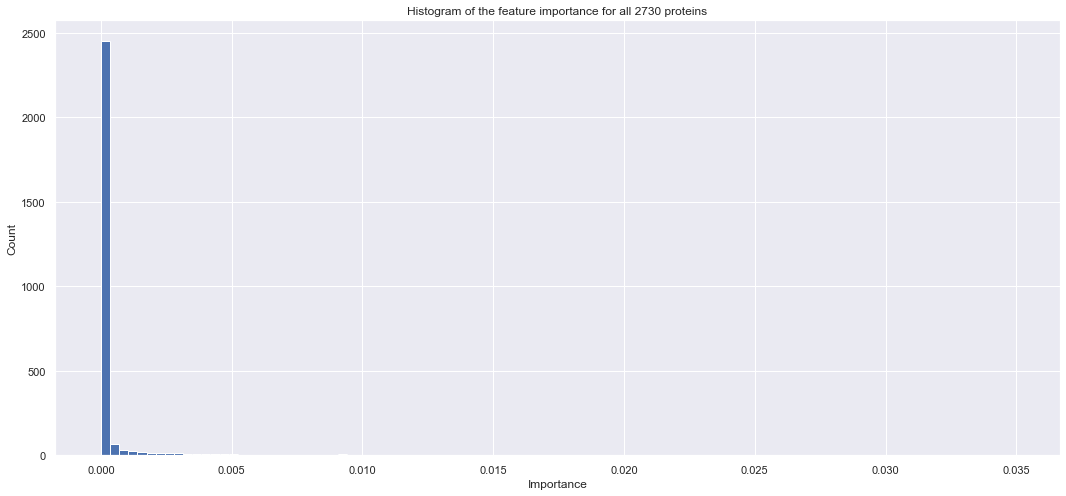

In [173]:
#sklearn.feature_selection
clf_XG = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            random_state=0)
clf_XG.fit(X,y)

#checkout importance in a histogram
plt.hist(clf_XG.feature_importances_, bins=100)
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")

selector = SelectFromModel(estimator = clf_XG, max_features=90)
selector.fit(X,y)

X_XG = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_XG.shape}")

joblib.dump(X_XG, "Models2/X_XG.pkl")
joblib.dump(selector.get_support(), "Models2/featSel_XG.pkl")

In [ ]:
#sklearn_gentic.GAFeatureSelection
clf_XG = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            use_label_encoder=False,
                            random_state=0)
clf_XG.fit(X,y)

evolved_estimator = GAFeatureSelectionCV(
    estimator           = clf_XG,
    cv                  = None,
    population_size     =25, 
    generations         =40,
    crossover_probability=0.8,
    mutation_probability= 0.1,
    n_jobs              = -1,
    scoring             = "accuracy")

# Train and select the features
evolved_estimator.fit(X, y)

#susbet data to only the chosen features
X_XGGA    = X[:, evolved_estimator.best_features_]

joblib.dump(X_XGGA, "Models2/X_XGGA.pkl")
joblib.dump(evolved_estimator.best_features_, "Models2/featSel_XGGA.pkl")


## Part 5: Model Training

#### To check which selected features from part 4 gives the best result, the Random Forest and XGboost is tested individually with each pool of selected features. 
#### The fifth feature selection will be the filtered proteins from part 2 with a p-value < 0.05 and a fold change > 2.0.


Both models run with the features of the klearn_featureselection, hence the feature selection of this module outperformed the sklearn.genetic.GAFeatureSelection.

### Results
As can be seen, the best performance with:
* Accuracy Random Forest: 0.763
* Accuracy XGBoost : 0.545
##### was achieved by using the **Random forest Model with the sklearn.selectFromModel module**

In [174]:
featSel_part2   = X_.columns.isin(protSel)
featSel_RF      = joblib.load("Models2/featSel_RF.pkl")
featSel_RFGA    = joblib.load("Models2/featSel_RFGA.pkl")   
featSel_XG      = joblib.load("Models2/featSel_XG.pkl")       #<-- WINNER for Xgboost very high for random forest
#featSel_XGGA   = joblib.load("Models2/featSel_XGGA.pkl")
featSel_XGGA = featSel_part2
#cancer dict
cancerTypes     = joblib.load("rawData/cancerTypes.pkl")

In [176]:
for featSel, featSelName in zip([featSel_part2,featSel_RF, featSel_RFGA, featSel_XG, featSel_XGGA], ["featSel_part2","featSel_RF", "featSel_RFGA", "featSel_XG", "featSel_XGGA"]):

    print("-----------------------------------")
    print("Feature Selection Method: \n")
    print(featSelName)
    print("-----------------------------------")
    #split the data
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[:,featSel], y, test_size=0.3, random_state=0)

        #   ----------------------------------------------------------

        #initialize Random Forest
        clf_RF = RandomForestClassifier(random_state=0)
        clf_RF.fit(X_train ,y_train)
        y_RFpred    = clf_RF.predict(X_test)

        print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
        print(classification_report(y_test, y_RFpred, target_names=cancerTypes))

    #   ----------------------------------------------------------

        #initialize XGBoost
        clf_XG = xgboost.XGBClassifier(tree_method='exact',
                                    eval_metric='mlogloss',
                                    random_state=0)

        clf_XG.fit(X_train ,y_train)
        y_XGpred = clf_XG.predict(X_test)

        print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGpred))
        print(classification_report(y_test, y_XGpred, target_names=cancerTypes))
        
    except:
        pass



-----------------------------------
Feature Selection Method: 

featSel_part2
-----------------------------------
-----------------------------------
Feature Selection Method: 

featSel_RF
-----------------------------------
-----------------------------------
Feature Selection Method: 

featSel_RFGA
-----------------------------------
-----------------------------------
Feature Selection Method: 

featSel_XG
-----------------------------------
-----------------------------------
Feature Selection Method: 

featSel_XGGA
-----------------------------------


In [177]:
#split the data
print('The original dataset with ', X.shape[0], ' items is now split into:')
X, X_val, y, y_val = train_test_split(X[:,featSel_RF], y, test_size=0.1, random_state=0)
txt1 ='X with {} items'.format(X.shape[0])
txt2 = 'X_val with {} items'.format(X_val.shape[0])
print(txt1)
print(txt2)

The original dataset with  162  items is now split into:


IndexError: boolean index did not match indexed array along dimension 1; dimension is 100 but corresponding boolean dimension is 2700

In [116]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X.shape)
print(X_train.shape)

(162, 100)
(113, 100)


### Random Forest

In [178]:
#initialize classifier
clf_RF = RandomForestClassifier(random_state=0)
clf_RF.fit(X_train ,y_train)
y_RFpred    = clf_RF.predict(X_test)

print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
print(classification_report(y_test, y_RFpred, target_names=cancerTypes))

Accuracy Random Forest: 0.6530612244897959
                   precision    recall  f1-score   support

    Breast Cancer       0.46      0.86      0.60         7
Colorectal Cancer       0.67      0.40      0.50        10
          Healthy       0.83      0.56      0.67         9
      Lung Cancer       0.86      0.60      0.71        10
Pancreatic Cancer       0.67      0.86      0.75         7
  Prostate Cancer       0.62      0.83      0.71         6

         accuracy                           0.65        49
        macro avg       0.69      0.68      0.66        49
     weighted avg       0.70      0.65      0.65        49



### XGBoost Classifier

In [179]:
#initialize classifier
clf_XG = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            use_lable_encoder=False,
                            random_state=0)

clf_XG.fit(X_train ,y_train)
y_XGpred = clf_XG.predict(X_test)

print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGpred))
print(classification_report(y_test, y_XGpred, target_names=cancerTypes))

/Users/kili/miniforge3/envs/datascience/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:10:48] WARNING: ../src/learner.cc:576: 
Parameters: { "use_lable_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy XGBoost Random Forest: 0.5918367346938775
                   precision    recall  f1-score   support

    Breast Cancer       0.31      0.57      0.40         7
Colorectal Cancer       0.62      0.50      0.56        10
          Healthy       0.45      0.56      0.50         9
      Lung Cancer       1.00      0.40      0.57        10
Pancreatic Cancer       0.75      0.86      0.80         7
  Prostate Cancer       1.00      0.83      0.91         6

         accuracy                           0.59        49
        macro avg       0.69      0.62      0.62        49
     weighted avg       0.69      0.59      0.60

## Part 6: Hyperparameter Tuning
In this chapter the model is optimized by hyperparameter tuning. A random grid search is applied to selected hyperparameters of both models.

The hyperparametertuning follows the instructions of the following publication https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 (31.12.21). 

Hyperparameter tuning needs time and resources. Therefore, after each hyperparameter tuning the model is run with optimized parameters, so hyperparameter tuning is not needed to be run if there is no time for it. 

Furthermore, be aware that each grid search results in different optimized parameters. We selected the best parameter we obtained by running the grid search several times with different conditions.

In [161]:
#initialize model
clf_RF    = RandomForestClassifier(random_state=0)

#Define hyperparameters for tuning
n_estimators_RF = [x for x in np.linspace(start=100, stop=1000, dtype=int)] #number of trees
criterion_RF    = ['gini', 'entropy'] #function to measure quality of a split
max_depth_RF = [int(x) for x in np.arange(1, 100)] #numbber of levels
max_depth_RF.append(None)
min_samples_split_RF = [int(x) for x in np.arange(2, 30)] #minimum number of samples required to split a note
min_samples_leaf_RF = [np.arange(start=1, stop=5)] #minimum number of samples required at each leaf node
max_features_RF = ['auto', 'sqrt', 'log2'] #number of features
bootstrap_RF = [True, False] #method of selecting samples for training

#initialize random grid with hyperparameters
random_grid_RF = {'n_estimators': n_estimators_RF,
            'criterion'         : criterion_RF,
            'max_features'      : max_features_RF,
            'max_depth'         : max_depth_RF,                        
            'min_samples_split' : min_samples_split_RF,
            'bootstrap'         : bootstrap_RF}

#define model parameters for random grid search
RF_random = RandomizedSearchCV(estimator=clf_RF,
                            param_distributions=random_grid_RF,
                            n_iter=300,
                            cv=15,
                            verbose=2,
                            n_jobs=-1)

#fit the random search model
RF_random.fit(X_train, y_train)

#get best hyperparameters from the model
RF_random.best_params_

Fitting 15 folds for each of 300 candidates, totalling 4500 fits


KeyboardInterrupt: 

In [180]:
#run model with optimized hyperparameters
params  = {'n_estimators': 742, 'min_samples_split': 8, 'max_features': 'log2', 'max_depth': 62, 'bootstrap': True, 'criterion': 'gini'}

clf_RF_tuned = RandomForestClassifier(n_estimators=742,
                                    min_samples_split=8,
                                    max_features='log2',
                                    max_depth=62,
                                    criterion='gini',
                                    bootstrap=True,
                                    random_state = 2)

clf_RF_tuned.fit(X_train ,y_train)
y_RFpred_tuned = clf_RF_tuned.predict(X_test)

print("Accuracy Random Forest with tuned hyperparameters:",metrics.accuracy_score(y_test , y_RFpred_tuned))
print(classification_report(y_test, y_RFpred_tuned, target_names=cancerTypes))

Accuracy Random Forest with tuned hyperparameters: 0.6122448979591837
                   precision    recall  f1-score   support

    Breast Cancer       0.40      0.57      0.47         7
Colorectal Cancer       0.71      0.50      0.59        10
          Healthy       0.71      0.56      0.63         9
      Lung Cancer       0.83      0.50      0.62        10
Pancreatic Cancer       0.67      0.86      0.75         7
  Prostate Cancer       0.50      0.83      0.62         6

         accuracy                           0.61        49
        macro avg       0.64      0.64      0.61        49
     weighted avg       0.66      0.61      0.61        49



In [119]:
#initialize model
clf_XG = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = ['mlogloss'])

#Define hyperparameters for tuning
eta_XGRF = [x for x in np.linspace(start=0.01, stop=0.75, num=20)] #step size shrinkage to prevent overfitting
gamma_XGRF = [x for x in np.linspace(start=0, stop=5, num=10)] #min split los
max_depth_XGRF = [x for x in np.arange(0, 30, step=2)] #numbber of levels
min_child_weight_XGRF = [x for x in np.linspace(start=0, stop=20, num=10)] #min sum of instant weight
max_delta_step_XGRF = [x for x in np.linspace(start=0, stop=20, num=10)] #mx delta step
subsample_XGRF = [x for x in np.linspace(start=0.1, stop=1.0, num=5)] #subbsample ratio of training instances
colsample_bytree_XGRF = [x for x in np.linspace(start=0.1, stop=1, num=5)] #method of subsampling columns
reg_lambda_XGRF = [int(x) for x in np.arange(start=1, stop=10)] #min split los
tree_method_XGRF = ['auto', 'approx', 'hist', 'gpu_hist'] #tree construction method
refresh_leaf_XGRF = [1, 0] #refresh updater

random_grid_XGRF = {'eta'           : eta_XGRF,
                'gamma'             : gamma_XGRF,
                'max_depth'         : max_depth_XGRF,
                'min_child_weight'  : min_child_weight_XGRF,
                'max_delta_step'    : max_delta_step_XGRF,
                'subsample_XGRF'    : subsample_XGRF,
                'colsample_bytree'  : colsample_bytree_XGRF,
                'reg_lambda'        : reg_lambda_XGRF,
                'tree_method'       : tree_method_XGRF,
                'refresh_leaf'      : refresh_leaf_XGRF}


#define model parameters for random grid search
XGRF_random = RandomizedSearchCV(estimator = clf_XG,
                        param_distributions =random_grid_XGRF,
                        n_iter=100,
                        cv=5,
                        verbose=0,
                        n_jobs=-1)

#fit the random search model
XGRF_random.fit(X_train, y_train)

#get best hyperparameters from the model
XGRF_random.best_params_

OverflowError: Python int too large to convert to C long

In [181]:
#run model with optimized hyperparameters

params  = {'tree_method': 'auto',
 'subsample': 1.0,
 'reg_lambda': 1,
 'refresh_leaf': 0,
 'min_child_weight': 8.88888888888889,
 'max_depth': 8,
 'max_delta_step': 2.2222222222222223,
 'max_bin': 268,
 'gamma': 2.2222222222222223,
 'colsample_bytree': 0.775}

clf_XG_tuned = xgboost.XGBClassifier(random_state=0, use_label_encoder = False, eval_metric = ['mlogloss'])

clf_XG_tuned.fit(X_train ,y_train)
y_XGpred_tuned = clf_XG_tuned.predict(X_test)

print("Accuracy XGBoost with tuned hyperparameters:",metrics.accuracy_score(y_test , y_XGpred_tuned))
print(classification_report(y_test, y_XGpred_tuned, target_names=cancerTypes))

Accuracy XGBoost with tuned hyperparameters: 0.5918367346938775
                   precision    recall  f1-score   support

    Breast Cancer       0.31      0.57      0.40         7
Colorectal Cancer       0.62      0.50      0.56        10
          Healthy       0.45      0.56      0.50         9
      Lung Cancer       1.00      0.40      0.57        10
Pancreatic Cancer       0.75      0.86      0.80         7
  Prostate Cancer       1.00      0.83      0.91         6

         accuracy                           0.59        49
        macro avg       0.69      0.62      0.62        49
     weighted avg       0.69      0.59      0.60        49



## Part 7: Model Validation

In [147]:
labels = [ k for i, k in (zip(clf_RF.classes_, cancerTypes))]

['Breast Cancer',
 'Colorectal Cancer',
 'Healthy',
 'Lung Cancer',
 'Pancreatic Cancer',
 'Prostate Cancer']

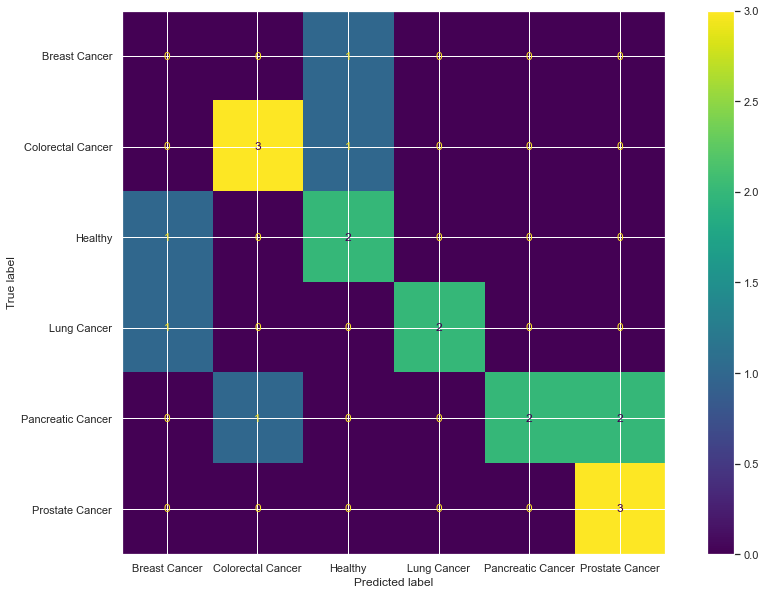

In [153]:
# visualize confusion matrix
y_val_RFpred =  clf_RF.predict(X_val)
cm = confusion_matrix(y_val, y_val_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax)

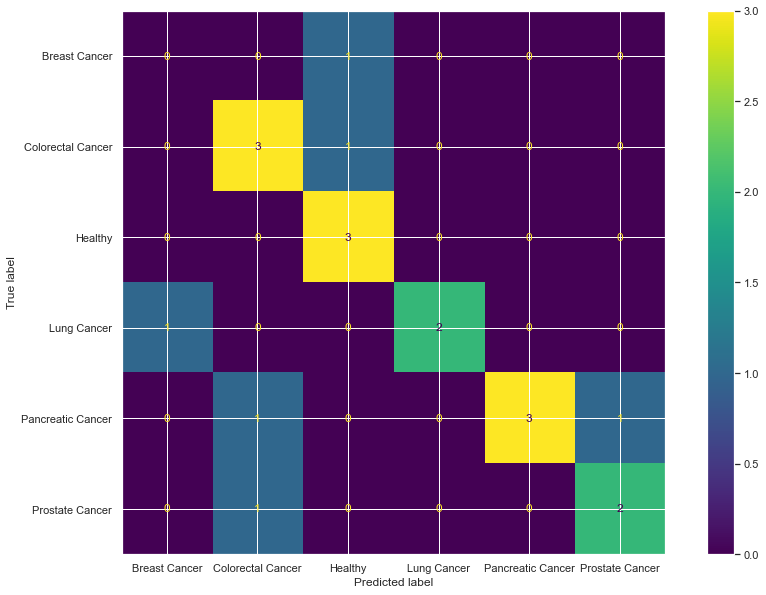

In [157]:
# visualize confusion matrix
y_val_XGpred =  clf_XG_tuned.predict(X_val)
cm = confusion_matrix(y_val, y_val_XGpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax)

In [183]:
print('Random Forest Accuracy: ')
print(classification_report(y_val, clf_RF.predict(X_val), target_names=cancerTypes))

print(classification_report(y_val, clf_RF_tuned.predict(X_val), target_names=cancerTypes))


print(classification_report(y_val, clf_XG.predict(X_val), target_names=cancerTypes))


print(classification_report(y_val, clf_XG_tuned.predict(X_val), target_names=cancerTypes))


Random Forest Accuracy: 
                   precision    recall  f1-score   support

    Breast Cancer       0.00      0.00      0.00         1
Colorectal Cancer       0.75      0.75      0.75         4
          Healthy       0.50      0.67      0.57         3
      Lung Cancer       1.00      0.67      0.80         3
Pancreatic Cancer       1.00      0.40      0.57         5
  Prostate Cancer       0.60      1.00      0.75         3

         accuracy                           0.63        19
        macro avg       0.64      0.58      0.57        19
     weighted avg       0.75      0.63      0.64        19

                   precision    recall  f1-score   support

    Breast Cancer       0.33      1.00      0.50         1
Colorectal Cancer       0.75      0.75      0.75         4
          Healthy       0.67      0.67      0.67         3
      Lung Cancer       1.00      0.67      0.80         3
Pancreatic Cancer       1.00      0.60      0.75         5
  Prostate Cancer       0.7

### Compare uncertainty of Data and Model

In [30]:
params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False} 

clf_RF_val = RandomForestClassifier(**params, random_state = 0)

scores = cross_val_score(clf_RF_val, X_train, y_train, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuRF = []
for rs in range(1,6):
    clf_RF_val2 = RandomForestClassifier(**params, random_state = random.randrange(rs))
    clf_RF_val2.fit(X_train, y_train)
    modAcuRF += [accuracy_score(y_test, clf_RF_val2.predict(X_test))]

Umodel = np.std(modAcuRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.065
Uncertainty in the model: 0.036
The model performance is 0.659 ± 0.065 ± 0.036


In [31]:
params  = {'tree_method': 'auto',
 'subsample': 1.0,
 'reg_lambda': 1,
 'refresh_leaf': 0,
 'min_child_weight': 8.88888888888889,
 'max_depth': 8,
 'max_delta_step': 2.2222222222222223,
 'max_bin': 268,
 'gamma': 2.2222222222222223,
 'colsample_bytree': 0.775}

clf_XG_tuned = xgboost.XGBClassifier(random_state=0, **params, use_label_encoder = False, eval_metric = ['mlogloss'])

scores = cross_val_score(clf_XG_tuned, X_train, y_train, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuXGRF = []
for rs in range(1,6):
    model = xgboost.XGBClassifier(random_state=random.randrange(rs), **params, use_label_encoder = False, eval_metric = ['mlogloss'])
    model.fit(X_train, y_train)
    modAcuXGRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuXGRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.077
Uncertainty in the model: 0.007
The model performance is 0.468 ± 0.077 ± 0.007


### Receiver Operating Characteristic (ROC)

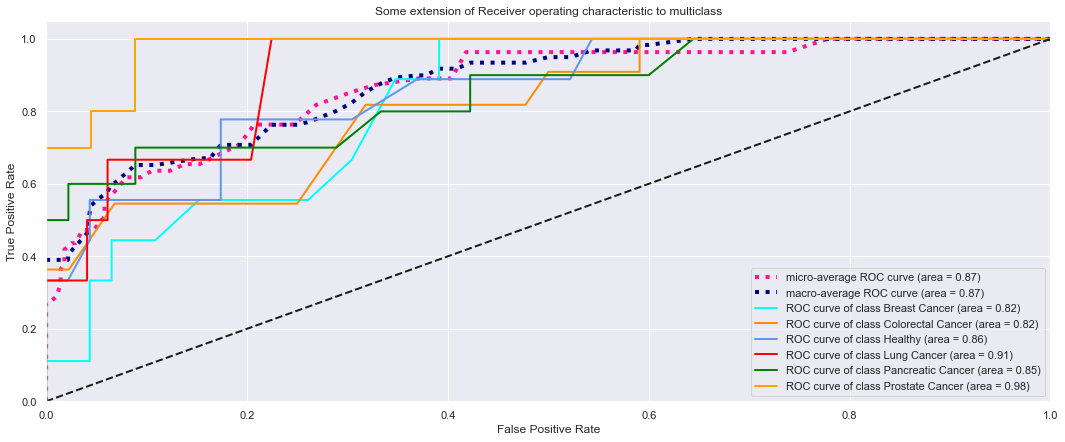

In [200]:

from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

n_classes = 6
X
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[:,featSel_RF], y, test_size=0.3, random_state=0)

#params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False}
params = {}
# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    RandomForestClassifier(**params, random_state = 0)
)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

lw = 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(18,7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(cancerTypes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Model explainability

### Using the package eli5

#### As can be seen from the first entry P05186 = Alkaline phosphatase this is a known biomarker for the following cancer: https://glygen.org/protein/P05186#
* colorectral cancer
* breast cancer
* lung cancer

#### or second entry Q01995 = Transgelin (https://research.bioinformatics.udel.edu/iptmnet/entry/Q01995/)
* lung cancer
* melanoma


In [202]:
clf_RF_tuned = RandomForestClassifier(**params, random_state = 2)

clf_RF_tuned.fit(X_train ,y_train)

eli5.show_weights(clf_RF_tuned, feature_names=X_.iloc[:, featSel_RF].columns.tolist())


Weight,Feature
0.0355 ± 0.0992,P02787
0.0331 ± 0.0966,P07288
0.0300 ± 0.0853,P02144
0.0267 ± 0.0780,Q01995
0.0234 ± 0.0695,P20742
0.0219 ± 0.0751,P05186
0.0192 ± 0.0671,P18065
0.0168 ± 0.0568,P41159
0.0159 ± 0.0567,P15144
0.0150 ± 0.0670,Q01518


In [208]:
eli5.sklearn.explain_prediction_tree_classifier(estimator = clf_RF_tuned, 
                                                feature_names=X_.iloc[:, featSel_XG].columns.tolist())

AttributeError: module 'eli5.sklearn' has no attribute 'explain_prediction_tree_classifier'

In [67]:
X_train[1].shape

(90,)

Create visualisations of a tree from our models

Random Forest Model:


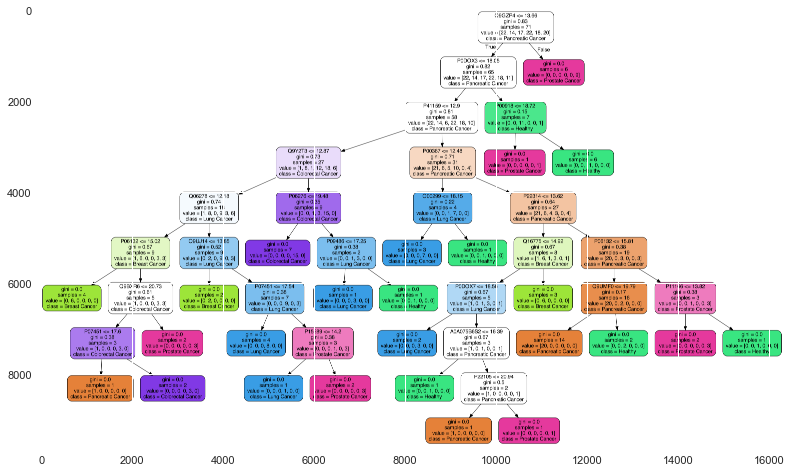

Tuned Random Forest Model: 


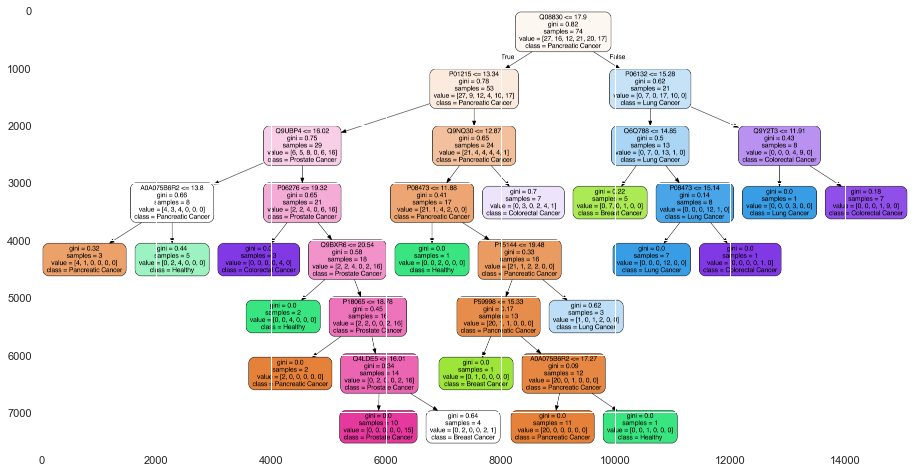

In [212]:
features_selected = X_.columns.values * selector.get_support()
finalfeatures = []
for features in features_selected:
    if features == '':
        next
    else:
        finalfeatures.append(features)

classes = list(set(zip(y_, y)))
classes.sort(key=lambda y: y[1])
classes_sorted = list(zip(*classes))[0]

# Visualise the model! 

estimator = clf_RF.estimators_[10]

# Export as dot file
export_graphviz(estimator, 
                out_file='tree_RF.dot', 
                feature_names = finalfeatures,
                class_names = classes_sorted,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# Convert to png
call(['dot', '-Tpng', 'tree_RF.dot', '-o', 'tree_RF.png', '-Gdpi=600'])
plt.imshow(plt.imread('tree_RF.png'))
print('Random Forest Model:')
plt.show()

# Extract single tree of the tuned random forest model
estimator = clf_RF_tuned.estimators_[10]

# Export as dot file
export_graphviz(estimator, 
                out_file='tree_RF_tuned.dot', 
                feature_names = finalfeatures,
                class_names = classes_sorted,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# Convert to png
call(['dot', '-Tpng', 'tree_RF_tuned.dot', '-o', 'tree_RF_tuned.png', '-Gdpi=600'])
plt.imshow(plt.imread('tree_RF_tuned.png'))
print('Tuned Random Forest Model: ')
plt.show()

<AxesSubplot:>

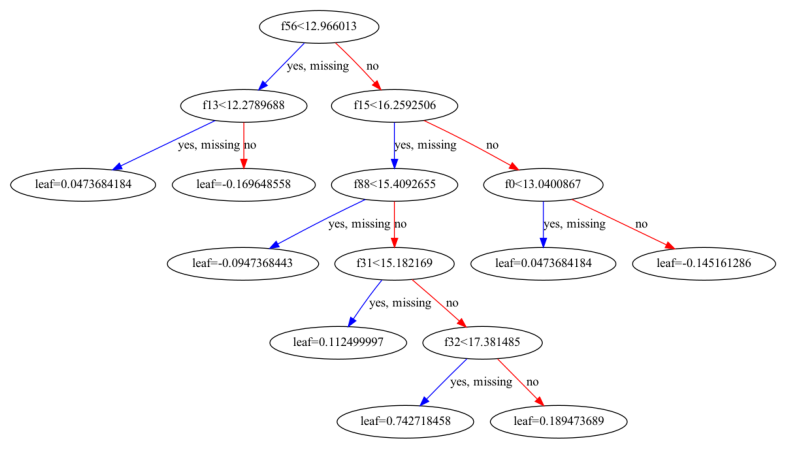

In [187]:
xgboost.plot_tree(clf_XG_tuned)

### Discussion and Outlook
The aim of this project work was to classify patient’s health status according to their corresponding protein fingerprints. As the code shows, two different classifiers (Random Forest and XGBoost) had been implemented successfully to predict a patient’s health status with an accuracy over 70 %. This code shows the importance of feature selection. Two different approaches were implented. The genetic approach did not manage to conduct a suitable feature selection. There can be many reasons for the results. GA provide  numerous parameters which can be change to improove performance. To determine those paraemters a lot of times is needed. With further improvments of the parameters the GA probably will be a suitable tool to for feature selection and will achieve comparable results like the sklearn.feature_selection. In the future, further methods should be conducted to find the best features.  A random grid search was applied to search for optimized hyperparameters. During the project work it was not possible to find optimized parameters. Even if the random grids search work, the proposed parameters did not result in an higher accuracy of both models. The accuracy was the same or lower as the defaul parameters. Meaning at this moment the defautl parameter of the random forest and XGBoost classifiers are the once with the highest accuracy. This does not mean, that the random grid search is not suitable for hyperparameter tuning per se. Hyperparameter tuning is time and ressource intensive and during the project work no better parameters could be found. However, this does not mean that there are better parameters than the defaults one (absence of evidence does not mean evidence of absence). For sure, more time and resources need to be investigated into the hyperparameter tuning. Furthermore, differen approaches should also been tested. Additional investigations in hyperparameter tuning will probably make this code even more reliable which is needed for a possible real live implementation. Overall, this works shows that digital approaches can be beneficial in the determination of cancer diagnosis. Computer-based analysis have a major potential and with further improvements and adjustments of the code the usability will continuously improve. With the right settings, code like this will be a helpful tool for specialists to classify diseases and help finding effective treatments.